In [186]:
import requests
import re
import sys
import pickle
import numpy as np
import util_cape
import html
from bs4 import BeautifulSoup
import pandas as pd

# Load all
cape_df = util_cape.load_cape_df()

## Initial query RMP for prof's page

In [4]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36"}

rmp_progress = {'total_count': len(cape_df.instr.unique()),
               'ok_count': 0,
               'dup_count': 0,
               'na_count': 0,
               'err_count': 0}

def get_rmp_url(prof_name):
    """ Takes prof name, query RMP and return rmp url for the page correspond to that professor """
    # This takes approximately 1/3 second to search (3000 queries -> 1000 seconds)
    global rmp_progress
    url = f"https://www.ratemyprofessors.com/search.jsp?queryoption=HEADER&queryBy=teacherName&schoolName=University+of+California+San+Diego&schoolID=1079&query={prof_name}"
    page = requests.get(url=url, headers=headers)
    pageData = page.text
    if page.status_code != 200:
        print(f'Error loading {url}! Internet?')
        rmp_progress['err_count'] += 1
        return ''
    pageDataTemp = re.findall(r'ShowRatings\.jsp\?tid=\d+', pageData)
    print("\n")
    total_count = sum([rmp_progress['ok_count'], rmp_progress['dup_count'], rmp_progress['na_count'], rmp_progress['err_count']])
    print(f"Searched:{total_count}/{rmp_progress['total_count']}, ok:{rmp_progress['ok_count']}, dup:{rmp_progress['dup_count']}, nf:{rmp_progress['na_count']}, err:{rmp_progress['err_count']}")
    if len(pageDataTemp) == 1:
        pageDataTemp = re.findall(r'ShowRatings\.jsp\?tid=\d+', pageData)[0]
        finalUrl = "https://www.ratemyprofessors.com/" + pageDataTemp
        rmp_progress['ok_count'] += 1
        return finalUrl
    elif len(pageDataTemp) > 1:
        print(f"{prof_name} has more than 1!")
        rmp_progress['dup_count'] += 1
        return ''
    else:
        print(f"{prof_name} not found!")
        rmp_progress['na_count'] += 1
        return ''

## Query from RMP to search each prof's page
**Only need to be run once**. It will take ~15 minutes depending on Internet speed.

In [ ]:
def instr_raw2search(raw):
    parsed = re.findall(r"(\w+), (\w+)", raw)
    if len(parsed) != 1:
        print(f"Cannot convert to search format: {raw}")
        return ''
    search = parsed[0][0] + '+' + parsed[0][1]
    return f"{search.upper()}"

rmp_df = pd.DataFrame()
rmp_df['instr_raw'] = cape_df.instr.unique()
rmp_df['instr_search'] = rmp_df['instr_raw'].apply(instr_raw2search)
rmp_df['rmp_html'] = np.nan
rmp_df['rmp_url'] = rmp_df['instr_search'].apply(get_rmp_url)
pickle.dump(rmp_df, open('rmp.pkl', 'wb'))

In [202]:
rmp_df = pickle.load(open('rmp.pkl', 'rb'))

In [203]:
# Find different professors who has same search results
invalid_idx = np.array([])

def verify_result(sub_df):
    global invalid_idx
    if not np.all(sub_df['instr_search'] == sub_df['instr_search'].iloc[0]):
        invalid_idx = np.append(invalid_idx, sub_df.index)
#         print("\n\nDropping:")
#         print(sub_df)
dup_rmp_urls = rmp_df.groupby(by='rmp_url').filter(lambda x: (x.shape[0] > 1) and (x.shape[0] < 10))
dup_rmp_urls.groupby(by='rmp_url').apply(verify_result)
rmp_df = rmp_df.drop(index=invalid_idx)

In [204]:
def get_rmp_html(row):
    rmp_url = row['rmp_url']
    idx = row['index']
    page = requests.get(rmp_url)
    total_count = sum([rmp_progress['ok_count'], rmp_progress['err_count']])
    print(f"{total_count}/{rmp_progress['total_count']}, ok:{rmp_progress['ok_count']}, err:{rmp_progress['err_count']}")
    if page.status_code != 200:
        print(f'Error loading {url}! HTTP{page.status_code}')
        rmp_progress['err_count'] += 1
        return np.nan
    rmp_df.loc[idx, 'rmp_html'] = html.unescape(page.content.decode("utf-8"))
    rmp_progress['ok_count'] += 1
    if rmp_progress['ok_count'] % 20 == 0:
        pickle.dump(rmp_df, open('rmp.pkl', 'wb'))

## Get each prof's page
**Only need to be run once. Automatically saves to file every 20 updates. Can continue previous progress**. It will take ~30 minutes depending on Internet speed.

In [205]:
rmp_working_df = rmp_df[(rmp_df['rmp_url'] != '') & (rmp_df['rmp_html'].isna())].copy()
rmp_working_df['index'] = rmp_working_df.index
# rmp_true_df['rmp_url'].to_frame(0).apply(lambda x: print(x), axis=1)
rmp_progress = {'total_count': rmp_working_df.shape[0],
               'ok_count': 0,
               'err_count': 0}
rmp_working_df[['rmp_url', 'index']].apply(get_rmp_html, axis=1)

0/2, ok:0, err:0
1/2, ok:1, err:0


3839    None
3850    None
dtype: object

In [206]:
def parse_rmp_html(html):
    print(f"{rmp_progress['ok_count']}/{rmp_progress['total_count']}, ok:{rmp_progress['ok_count']}, err:{rmp_progress['err_count']}")
    
    soup = BeautifulSoup(html, 'html.parser')
    RE_TEACHER_FEEDBACK_PARSER = r'^(\d+\.?\d*%?)(.+)'
    RE_RATING_NUMBER_PARSER = f'on (\d+) ratings'
    no_rating_headline = soup.find('div', class_='headline')  # If prof has 0 ratings
    if no_rating_headline is not None:
        return
    prof_name = soup.find('div', class_='NameTitle__Name-dowf0z-0 cjgLEI').text
    rmp_score = float(soup.find('div', class_='RatingValue__Numerator-qw8sqy-2 gxuTRq').text)
    rating_number_str = soup.find('div', class_='RatingValue__NumRatings-qw8sqy-0 hDaWgM').text
    rmp_rating_number = int(re.findall(RE_RATING_NUMBER_PARSER, unicodedata.normalize("NFKD", rating_number_str))[0])

    rmp_take_again = -1
    rmp_diff = -1
    for i in soup.find('div', class_='TeacherFeedback__StyledTeacherFeedback-gzhlj7-0 jCDePN'):
        parsed = re.findall(RE_TEACHER_FEEDBACK_PARSER, i.text)
        if len(parsed) == 1 and len(parsed[0]) == 2:
            parsed = parsed[0]
            if parsed[1] == 'Would take again':
                assert parsed[0][-1] == '%'
                rmp_take_again = int(parsed[0][:-1]) / 100.0
            elif parsed[1] == 'Level of Difficulty':
                rmp_diff = float(parsed[0])
            else:
                print("Unrecognized teacher feedback type {parsed}!")
        else:
            print(f"Cannot parse {i.text}!")
            rmp_progress['err_count'] += 1
#     print(f"{prof_name}: score{rmp_score}, ratings:{rmp_rating_number}")
    rmp_progress['ok_count'] += 1
    return prof_name, rmp_score, rmp_rating_number, rmp_take_again, rmp_diff

## Parse RMP Data
This should take about a minute

In [207]:
rmp_df = rmp_df.dropna()
rmp_progress = {'total_count': rmp_df.shape[0],
               'ok_count': 0,
               'err_count': 0}
rmp_df['rmp_parsed'] = rmp_df.loc[:, 'rmp_html'].apply(parse_rmp_html)
rmp_df[['rmp_name', 'rmp_score', 'rmp_rating_count', 'rmp_take_again', 'rmp_difficulty']] = pd.DataFrame(rmp_df['rmp_parsed'].tolist(), index=rmp_df.index)

0/2064, ok:0, err:0
1/2064, ok:1, err:0
2/2064, ok:2, err:0
3/2064, ok:3, err:0
4/2064, ok:4, err:0
5/2064, ok:5, err:0
6/2064, ok:6, err:0
7/2064, ok:7, err:0
7/2064, ok:7, err:0
8/2064, ok:8, err:0
9/2064, ok:9, err:0
9/2064, ok:9, err:0
10/2064, ok:10, err:0
11/2064, ok:11, err:0
12/2064, ok:12, err:0
12/2064, ok:12, err:0
13/2064, ok:13, err:0
14/2064, ok:14, err:0
15/2064, ok:15, err:0
16/2064, ok:16, err:0
17/2064, ok:17, err:0
18/2064, ok:18, err:0
19/2064, ok:19, err:0
20/2064, ok:20, err:0
21/2064, ok:21, err:0
22/2064, ok:22, err:0
23/2064, ok:23, err:0
24/2064, ok:24, err:0
25/2064, ok:25, err:0
26/2064, ok:26, err:0
27/2064, ok:27, err:0
28/2064, ok:28, err:0
29/2064, ok:29, err:0
30/2064, ok:30, err:0
31/2064, ok:31, err:0
32/2064, ok:32, err:0
33/2064, ok:33, err:0
34/2064, ok:34, err:0
35/2064, ok:35, err:0
36/2064, ok:36, err:0
37/2064, ok:37, err:0
38/2064, ok:38, err:0
39/2064, ok:39, err:0
40/2064, ok:40, err:0
41/2064, ok:41, err:0
42/2064, ok:42, err:0
43/2064, ok:

336/2064, ok:336, err:0
337/2064, ok:337, err:0
338/2064, ok:338, err:0
339/2064, ok:339, err:0
340/2064, ok:340, err:0
341/2064, ok:341, err:0
342/2064, ok:342, err:0
343/2064, ok:343, err:0
344/2064, ok:344, err:0
345/2064, ok:345, err:0
346/2064, ok:346, err:0
347/2064, ok:347, err:0
348/2064, ok:348, err:0
349/2064, ok:349, err:0
350/2064, ok:350, err:0
351/2064, ok:351, err:0
352/2064, ok:352, err:0
353/2064, ok:353, err:0
354/2064, ok:354, err:0
355/2064, ok:355, err:0
356/2064, ok:356, err:0
357/2064, ok:357, err:0
358/2064, ok:358, err:0
359/2064, ok:359, err:0
359/2064, ok:359, err:0
360/2064, ok:360, err:0
361/2064, ok:361, err:0
362/2064, ok:362, err:0
363/2064, ok:363, err:0
364/2064, ok:364, err:0
365/2064, ok:365, err:0
366/2064, ok:366, err:0
366/2064, ok:366, err:0
367/2064, ok:367, err:0
368/2064, ok:368, err:0
369/2064, ok:369, err:0
370/2064, ok:370, err:0
371/2064, ok:371, err:0
372/2064, ok:372, err:0
373/2064, ok:373, err:0
374/2064, ok:374, err:0
375/2064, ok:375

657/2064, ok:657, err:0
657/2064, ok:657, err:0
658/2064, ok:658, err:0
659/2064, ok:659, err:0
660/2064, ok:660, err:0
661/2064, ok:661, err:0
662/2064, ok:662, err:0
663/2064, ok:663, err:0
664/2064, ok:664, err:0
665/2064, ok:665, err:0
666/2064, ok:666, err:0
667/2064, ok:667, err:0
668/2064, ok:668, err:0
669/2064, ok:669, err:0
670/2064, ok:670, err:0
671/2064, ok:671, err:0
672/2064, ok:672, err:0
673/2064, ok:673, err:0
674/2064, ok:674, err:0
675/2064, ok:675, err:0
676/2064, ok:676, err:0
677/2064, ok:677, err:0
678/2064, ok:678, err:0
679/2064, ok:679, err:0
680/2064, ok:680, err:0
681/2064, ok:681, err:0
682/2064, ok:682, err:0
683/2064, ok:683, err:0
684/2064, ok:684, err:0
685/2064, ok:685, err:0
686/2064, ok:686, err:0
687/2064, ok:687, err:0
688/2064, ok:688, err:0
689/2064, ok:689, err:0
690/2064, ok:690, err:0
691/2064, ok:691, err:0
692/2064, ok:692, err:0
693/2064, ok:693, err:0
694/2064, ok:694, err:0
695/2064, ok:695, err:0
696/2064, ok:696, err:0
697/2064, ok:697

984/2064, ok:984, err:0
985/2064, ok:985, err:0
986/2064, ok:986, err:0
987/2064, ok:987, err:0
988/2064, ok:988, err:0
989/2064, ok:989, err:0
990/2064, ok:990, err:0
991/2064, ok:991, err:0
992/2064, ok:992, err:0
993/2064, ok:993, err:0
994/2064, ok:994, err:0
995/2064, ok:995, err:0
995/2064, ok:995, err:0
996/2064, ok:996, err:0
997/2064, ok:997, err:0
998/2064, ok:998, err:0
999/2064, ok:999, err:0
1000/2064, ok:1000, err:0
1000/2064, ok:1000, err:0
1000/2064, ok:1000, err:0
1001/2064, ok:1001, err:0
1002/2064, ok:1002, err:0
1003/2064, ok:1003, err:0
1004/2064, ok:1004, err:0
1005/2064, ok:1005, err:0
1006/2064, ok:1006, err:0
1007/2064, ok:1007, err:0
1007/2064, ok:1007, err:0
1008/2064, ok:1008, err:0
1009/2064, ok:1009, err:0
1010/2064, ok:1010, err:0
1011/2064, ok:1011, err:0
1012/2064, ok:1012, err:0
1013/2064, ok:1013, err:0
1013/2064, ok:1013, err:0
1014/2064, ok:1014, err:0
1015/2064, ok:1015, err:0
1016/2064, ok:1016, err:0
1017/2064, ok:1017, err:0
1018/2064, ok:1018, 

1290/2064, ok:1290, err:0
1291/2064, ok:1291, err:0
1292/2064, ok:1292, err:0
1293/2064, ok:1293, err:0
1294/2064, ok:1294, err:0
1295/2064, ok:1295, err:0
1296/2064, ok:1296, err:0
1297/2064, ok:1297, err:0
1297/2064, ok:1297, err:0
1298/2064, ok:1298, err:0
1299/2064, ok:1299, err:0
1300/2064, ok:1300, err:0
1301/2064, ok:1301, err:0
1302/2064, ok:1302, err:0
1303/2064, ok:1303, err:0
1304/2064, ok:1304, err:0
1305/2064, ok:1305, err:0
1306/2064, ok:1306, err:0
1307/2064, ok:1307, err:0
1308/2064, ok:1308, err:0
1309/2064, ok:1309, err:0
1310/2064, ok:1310, err:0
1310/2064, ok:1310, err:0
1311/2064, ok:1311, err:0
1312/2064, ok:1312, err:0
1313/2064, ok:1313, err:0
1314/2064, ok:1314, err:0
1315/2064, ok:1315, err:0
1316/2064, ok:1316, err:0
1317/2064, ok:1317, err:0
1318/2064, ok:1318, err:0
1319/2064, ok:1319, err:0
1320/2064, ok:1320, err:0
1321/2064, ok:1321, err:0
1322/2064, ok:1322, err:0
1323/2064, ok:1323, err:0
1324/2064, ok:1324, err:0
1324/2064, ok:1324, err:0
1325/2064, o

1595/2064, ok:1595, err:0
1596/2064, ok:1596, err:0
1597/2064, ok:1597, err:0
1598/2064, ok:1598, err:0
1599/2064, ok:1599, err:0
1600/2064, ok:1600, err:0
1601/2064, ok:1601, err:0
1602/2064, ok:1602, err:0
1603/2064, ok:1603, err:0
1604/2064, ok:1604, err:0
1605/2064, ok:1605, err:0
1606/2064, ok:1606, err:0
1607/2064, ok:1607, err:0
1608/2064, ok:1608, err:0
1609/2064, ok:1609, err:0
1610/2064, ok:1610, err:0
1611/2064, ok:1611, err:0
1612/2064, ok:1612, err:0
1613/2064, ok:1613, err:0
1614/2064, ok:1614, err:0
1615/2064, ok:1615, err:0
1616/2064, ok:1616, err:0
1617/2064, ok:1617, err:0
1618/2064, ok:1618, err:0
1619/2064, ok:1619, err:0
1620/2064, ok:1620, err:0
1621/2064, ok:1621, err:0
1622/2064, ok:1622, err:0
1623/2064, ok:1623, err:0
1624/2064, ok:1624, err:0
1625/2064, ok:1625, err:0
1626/2064, ok:1626, err:0
1627/2064, ok:1627, err:0
1628/2064, ok:1628, err:0
1629/2064, ok:1629, err:0
1630/2064, ok:1630, err:0
1631/2064, ok:1631, err:0
1632/2064, ok:1632, err:0
1633/2064, o

1902/2064, ok:1902, err:0
1902/2064, ok:1902, err:0
1903/2064, ok:1903, err:0
1904/2064, ok:1904, err:0
1905/2064, ok:1905, err:0
1905/2064, ok:1905, err:0
1906/2064, ok:1906, err:0
1907/2064, ok:1907, err:0
1908/2064, ok:1908, err:0
1909/2064, ok:1909, err:0
1910/2064, ok:1910, err:0
1911/2064, ok:1911, err:0
1911/2064, ok:1911, err:0
1912/2064, ok:1912, err:0
1913/2064, ok:1913, err:0
1914/2064, ok:1914, err:0
1914/2064, ok:1914, err:0
1915/2064, ok:1915, err:0
1915/2064, ok:1915, err:0
1916/2064, ok:1916, err:0
1917/2064, ok:1917, err:0
1918/2064, ok:1918, err:0
1919/2064, ok:1919, err:0
1920/2064, ok:1920, err:0
1921/2064, ok:1921, err:0
1921/2064, ok:1921, err:0
1922/2064, ok:1922, err:0
1923/2064, ok:1923, err:0
1924/2064, ok:1924, err:0
1925/2064, ok:1925, err:0
1926/2064, ok:1926, err:0
1927/2064, ok:1927, err:0
1927/2064, ok:1927, err:0
1928/2064, ok:1928, err:0
1929/2064, ok:1929, err:0
1930/2064, ok:1930, err:0
1931/2064, ok:1931, err:0
1932/2064, ok:1932, err:0
1933/2064, o

In [233]:
pickle.dump(rmp_df[['instr_raw', 'rmp_name', 'rmp_score', 'rmp_rating_count', 'rmp_take_again', 'rmp_difficulty']], open('rmp_final.pkl', 'wb'))
rmp_df.head()

,instr_raw,instr_search,rmp_url,rmp_html,rmp_parsed,rmp_name,rmp_score,rmp_rating_count,rmp_take_again,rmp_difficulty
2,"Gagneux, Pascal",GAGNEUX+PASCAL,https://www.ratemyprofessors.com/ShowRatings.j...,\n <!DOCTYPE html>\n <html >\n <hea...,"(Pascal Gagneux, 4.8, 4, 1.0, 2.8)",Pascal Gagneux,4.8,4.0,1.00,2.8
7,"Stewart, Alexander B",STEWART+ALEXANDER,https://www.ratemyprofessors.com/ShowRatings.j...,\n <!DOCTYPE html>\n <html >\n <hea...,"(Alexander Stewart, 3.6, 37, 0.69, 2.9)",Alexander Stewart,3.6,37.0,0.69,2.9
9,"Goldstein, Paul S",GOLDSTEIN+PAUL,https://www.ratemyprofessors.com/ShowRatings.j...,\n <!DOCTYPE html>\n <html >\n <hea...,"(Paul Goldstein, 3.5, 39, 0.67, 2.5)",Paul Goldstein,3.5,39.0,0.67,2.5
12,"Borrero, Mario Ricardo",BORRERO+MARIO,https://www.ratemyprofessors.com/ShowRatings.j...,\n <!DOCTYPE html>\n <html >\n <hea...,"(Mario Borrero, 4.0, 1, 1.0, 3.0)",Mario Borrero,4.0,1.0,1.00,3.0
13,"Christie, Veronica Ann",CHRISTIE+VERONICA,https://www.ratemyprofessors.com/ShowRatings.j...,\n <!DOCTYPE html>\n <html >\n <hea...,"(Veronica Christie, 5.0, 2, 1.0, 3.0)",Veronica Christie,5.0,2.0,1.00,3.0


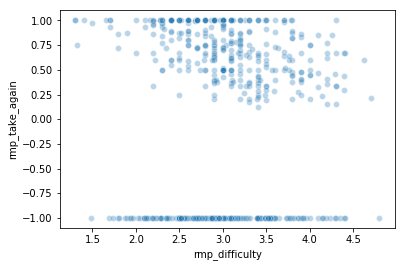

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
rmp_df_new = rmp_df[rmp_df['rmp_rating_count'] > 20]
sns.scatterplot(x='rmp_difficulty', y='rmp_take_again', data=rmp_df_new, alpha=0.3)